In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#For a new user that needs to install
#!pip install wrapt --upgrade --ignore-installed
#!pip install tensorflow-gpu
#!pip install keras

In [3]:
import csv
import time
import sys
import os 

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
#put your path in possible_paths 
possible_paths = ["..\\utils\\", "../../utils/"]
for path in possible_paths:
    if os.path.isdir(path):
        utils_path = path
        
sys.path.insert(0, utils_path)   
sys.path.insert(0, utils_path)  

import utils as ut
import fancyplots as fp
from regr_models import neuralNewtorkRegression

In [5]:
#When a library is updated, run
import importlib
importlib.reload(ut)

<module 'utils' from '/home/simone/repos/IPAM2021_ML/algo/NN_tf/../../utils/utils.py'>

## Input options

In [6]:
# training options
write_output     = False
remove_some_mass = False
epochs           = 100
validation_split = 0.2
batch_size       = 128
verbose_training = False
hlayers_sizes    = (100,);
learning_rate    = 0.001
scaler_type      = 'minmax' # standard, minmax, mixed
hidden_activation= 'relu'
out_activation   = 'linear' # sigmoid, linear, linear_cut, linear_cut_T3, linear_cut_lb, linear_cut_mod
loss_function    = 'mse'

use_uniform_q = False

save_plots = False # used only for multiepochs plots (not for the histograms)
#plots_dir  = '/home/simone/repos/IPAM2021_ML/notes/Figs/'
plots_dir = ''

# data paths
regr_data_dirs = ["../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/",
                  "..\\GSTLAL_EarlyWarning_Dataset\\Dataset\\m1m2Mc\\"]
for path in regr_data_dirs:
    if os.path.isdir(path):
        if use_uniform_q:
            regr_data_dir = path.replace('m1m2Mc', 'm1m2Mc_uniform_q')
        else:
            regr_data_dir = path  
        print(regr_data_dir)

../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/


## Load dataset

Histogram: injected


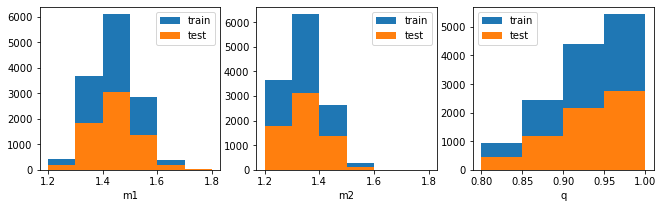

Histogram: recovered


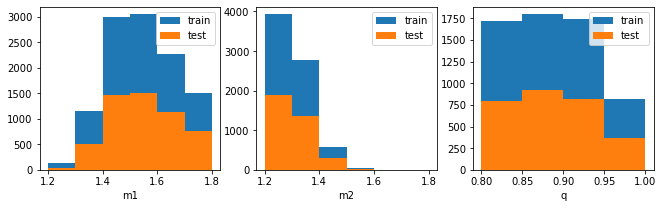

In [7]:
# load data
features_names       = ['m1', 'm2', 'Mc']
data_paths           = {}
data_paths['xtrain'] = regr_data_dir+'xtrain.csv'
data_paths['ytrain'] = regr_data_dir+'ytrain.csv'
data_paths['xtest']  = regr_data_dir+'xtest.csv'
data_paths['ytest']  = regr_data_dir+'ytest.csv'

rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                       remove_some_mass=remove_some_mass,
                       scaler_type=None)
xtrain_notnormalized = rdl_out['xtrain']
ytrain_notnormalized = rdl_out['ytrain']
xtest_notnormalized  = rdl_out['xtest']
ytest_notnormalized  = rdl_out['ytest']
labels               = rdl_out['labels']

# inj-histogram
print('Histogram: injected')
inj_train = ytrain_notnormalized
inj_test  = ytest_notnormalized
fig, axs = plt.subplots(1,3, figsize=(11, 3))
axs[0].hist(inj_train[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='train')
axs[0].hist(inj_test[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='test')
axs[0].set_xlabel('m1')
axs[0].legend()
axs[1].hist(inj_train[:,1],bins=np.arange(1.2,1.9,0.1), alpha=1, label='train')
axs[1].hist(inj_test[:,1],bins=np.arange(1.2,1.9,0.1), alpha=1, label='test')
axs[1].set_xlabel('m2')
axs[1].legend()
qtrain = inj_train[:,1]/inj_train[:,0]
qtest  = inj_test[:,1]/inj_test[:,0]
axs[2].hist(qtrain,bins=np.arange(0.8,1.01,0.05), alpha=1, label='train')
axs[2].hist(qtest, bins=np.arange(0.8,1.01,0.05), alpha=1, label='test')
axs[2].set_xlabel('q')
axs[2].legend()
plt.show()

# rec-histogram
print('Histogram: recovered')
rec_train = xtrain_notnormalized
rec_test  = xtest_notnormalized
fig, axs = plt.subplots(1,3, figsize=(11, 3))
axs[0].hist(rec_train[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='train')
axs[0].hist(rec_test[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='test')
axs[0].set_xlabel('m1')
axs[0].legend()
axs[1].hist(rec_train[:,1],bins=np.arange(1.2,1.9,0.1), alpha=1, label='train')
axs[1].hist(rec_test[:,1],bins=np.arange(1.2,1.9,0.1), alpha=1, label='test')
axs[1].set_xlabel('m2')
axs[1].legend()
qtrain = rec_train[:,1]/rec_train[:,0]
qtest  = rec_test[:,1]/rec_test[:,0]
axs[2].hist(qtrain,bins=np.arange(0.8,1.01,0.05), alpha=1, label='train')
axs[2].hist(qtest, bins=np.arange(0.8,1.01,0.05), alpha=1, label='test')
axs[2].set_xlabel('q')
axs[2].legend()
plt.show()


## Regression (m1,m2)

********************************************************************************
Layers: 100 
trainable pramaters: 502
train time: 8.985
********************************************************************************

Final loss     : 0.03074
Final R2 mean  : 0.76312
R2[ 0]         : 0.74153
R2[ 1]         : 0.78471


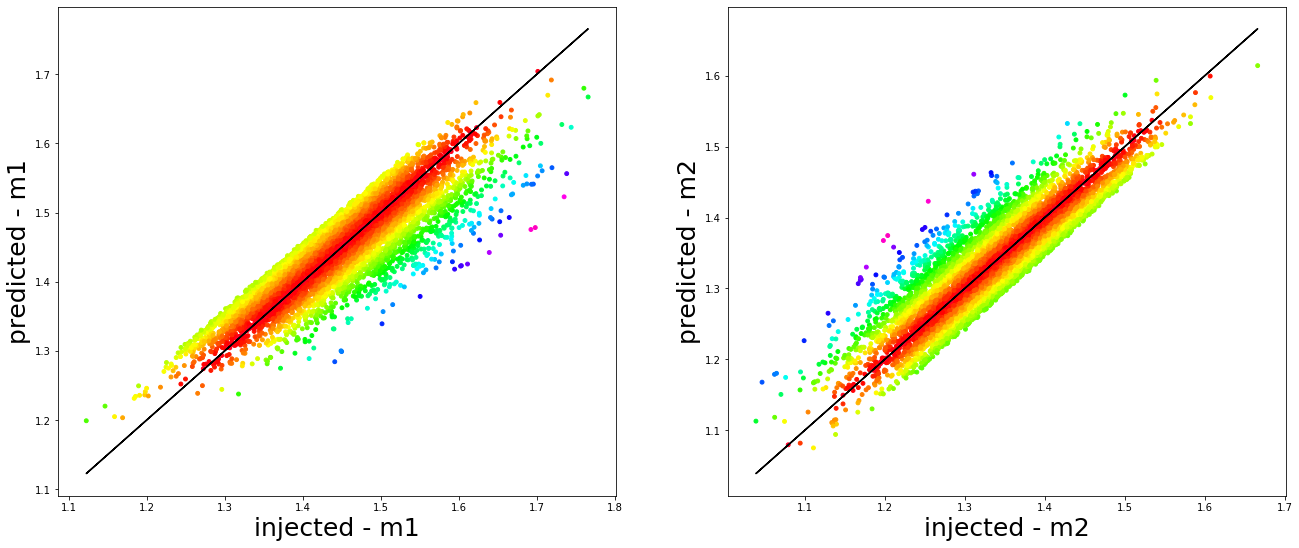

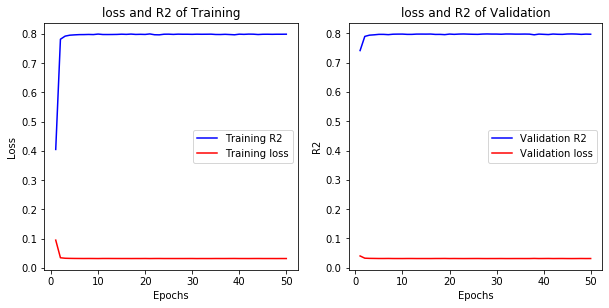

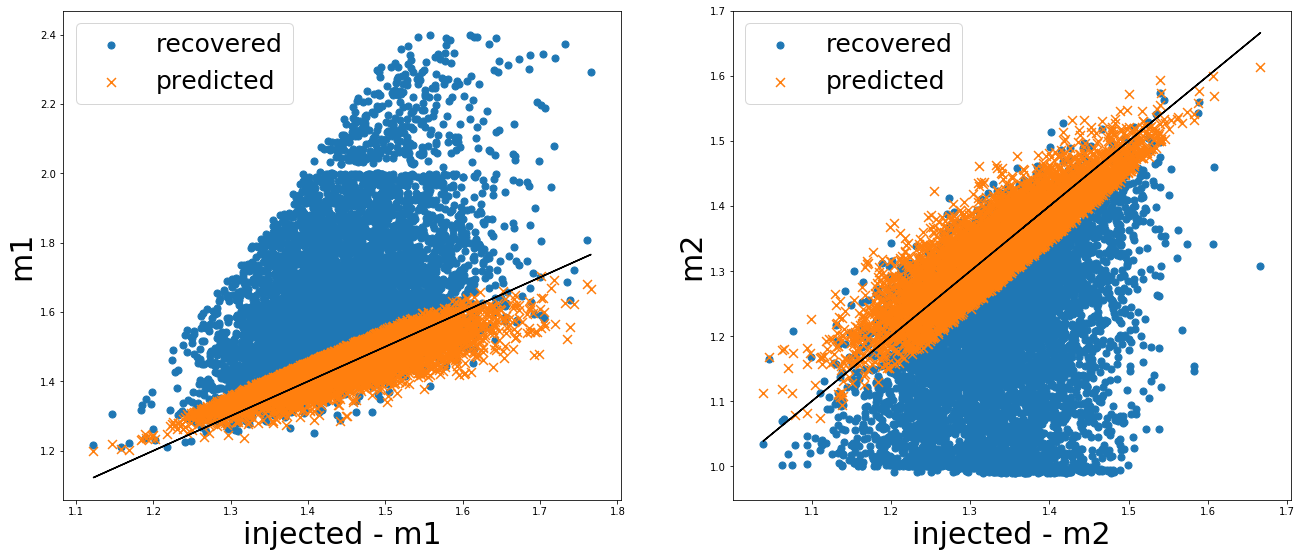

********************************************************************************
m1 vs m2: injected, recovered, predicted
********************************************************************************


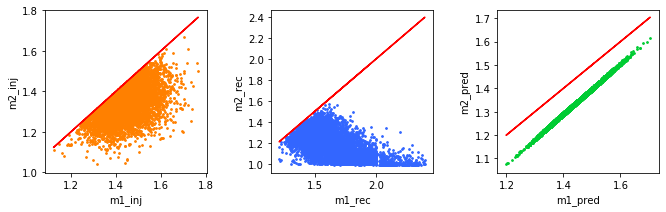

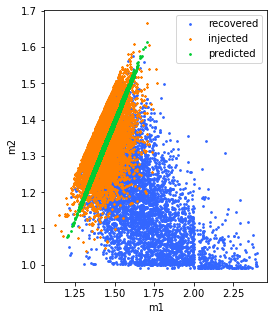

********************************************************************************
m1 vs q: injected, recovered, predicted (indirectly)
********************************************************************************


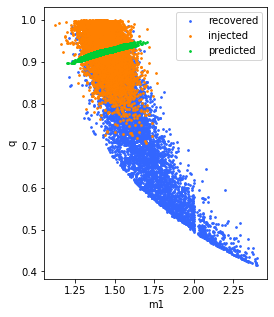

---------------------------------
m1 mean error: 0.022783965601688452
m2 mean error: 0.02253096540250693
Mc mean error: 0.00038579490886876135
q  mean error: 0.04569218490805813


In [8]:
# train model
epochs_m1m2 = 50

xtrain_notnorm_m1m2 = xtrain_notnormalized[:,0:2]
ytrain_notnorm_m1m2 = ytrain_notnormalized[:,0:2]
xtest_notnorm_m1m2  = xtest_notnormalized[:,0:2]
ytest_notnorm_m1m2  = ytest_notnormalized[:,0:2]
labels_m1m2         = labels[0:2]

t0 = time.perf_counter()
outNN = neuralNewtorkRegression(xtrain_notnorm_m1m2, ytrain_notnorm_m1m2,
            scaler_type       = scaler_type,                   
            epochs            = epochs_m1m2, 
            batch_size        = batch_size, 
            learning_rate     = learning_rate,          
            validation_split  = validation_split,   
            verbose           = verbose_training,             
            hlayers_sizes     = hlayers_sizes,          
            out_activation    = out_activation,        
            hidden_activation = hidden_activation,
            loss_function     = 'mse')
train_time = time.perf_counter()-t0

model    = outNN["model"]
history  = outNN["history"]
Npars    = outNN["Npars"]
scaler_x = outNN["scaler_x"]
scaler_y = outNN["scaler_y"]

xtest = scaler_x.transform(xtest_notnorm_m1m2)
ytest = scaler_y.transform(ytest_notnorm_m1m2)

# predict
ypredicted = model.predict(xtest)

# print some information
metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)

# show plots and print info
asterisks = '*'*80
print(asterisks)
print('Layers: ', end='')
for layer in hlayers_sizes:
    print(layer,end=' ')
print('\ntrainable pramaters: ', Npars, \
      '\ntrain time: {:.3f}'.format(train_time), '\n', \
      asterisks, sep='', end='\n')
ut.printMetrics(metrics_dict)

# save info/score/model in the dictionary
struct_m1m2                     = lambda:0
struct_m1m2.Npars               = Npars
struct_m1m2.metrics             = metrics_dict
struct_m1m2.train_time          = train_time
struct_m1m2.Nlayers             = len(hlayers_sizes)
struct_m1m2.hlayers_sizes       = hlayers_sizes
struct_m1m2.epochs              = epochs
struct_m1m2.batch_size          = batch_size
struct_m1m2.scaler_type         = scaler_type
struct_m1m2.out_activation      = out_activation
struct_m1m2.hidden_activation   = hidden_activation
struct_m1m2.learning_rate       = learning_rate
struct_m1m2.prediction          = ypredicted
struct_m1m2.prediction_rescaled = scaler_y.inverse_transform(ypredicted)
struct_m1m2.loss_function       = loss_function
struct_m1m2.scaler_x            = scaler_x
struct_m1m2.scaler_y            = scaler_y
struct_m1m2.model               = model
struct_m1m2.history             = history

# plots
fp.regrPredictionPlots(ytest, ypredicted, labels_m1m2, scaler=scaler_y)
fp.plotHistory(history)
fp.checkRegressionPlot(xtest, ytest, ypredicted, labels_m1m2, \
                   scaler_y=scaler_y, scaler_x=scaler_x)
fp.plotInjRecPred(ytest_notnorm_m1m2, xtest_notnorm_m1m2, \
                  struct_m1m2.prediction_rescaled, idx_Mc=None)

# mean errors 
m1_inj  = ytest_notnormalized[:,0]
m2_inj  = ytest_notnormalized[:,1]
Mc_inj  = ut.chirpMass(m1_inj, m2_inj)
m1_pred = struct_m1m2.prediction_rescaled[:,0]
m2_pred = struct_m1m2.prediction_rescaled[:,1]
Mc_pred = ut.chirpMass(m1_pred, m2_pred)
q_inj   = m2_inj /m1_inj
q_pred  = m2_pred/m1_pred

prediction_m1m2 = np.column_stack((m1_pred, m2_pred, Mc_pred))
struct_m1m2.prediction = prediction_m1m2

error_m1 = (m1_inj-m1_pred)/m1_inj
error_m2 = (m2_inj-m2_pred)/m2_inj
error_Mc = (Mc_inj-Mc_pred)/Mc_inj
error_q  = (q_inj - q_pred)/q_inj
m1_mean_error = np.mean(np.abs(error_m1))
m2_mean_error = np.mean(np.abs(error_m2))
Mc_mean_error = np.mean(np.abs(error_Mc))
q_mean_error  = np.mean(np.abs(error_q))
print('---------------------------------')
print('m1 mean error:', m1_mean_error)
print('m2 mean error:', m2_mean_error)
print('Mc mean error:', Mc_mean_error)
print('q  mean error:', q_mean_error)

struct_m1m2.error_m1 = error_m1
struct_m1m2.error_m2 = error_m2
struct_m1m2.error_Mc = error_Mc
struct_m1m2.error_q  = error_q
struct_m1m2.me_m1 = m1_mean_error
struct_m1m2.me_m2 = m2_mean_error
struct_m1m2.me_Mc = Mc_mean_error
struct_m1m2.me_q  =  q_mean_error

## Test

In [9]:
def ErrorHistograms_m1m2(struct_m1m2, injected, recovered, \
                         label1="rec", label2="pred", color1=[0.8,0.8,0.8], color2=[0,1,0]):
    m1_inj  = injected[:,0]
    m2_inj  = injected[:,1]
    Mc_inj  = injected[:,2]
    q_inj   = m2_inj /m1_inj

    m1_rec  = recovered[:,0]
    m2_rec  = recovered[:,1]
    Mc_rec  = recovered[:,2]
    q_rec   = m2_rec /m1_rec

    nbins = 30

    fig, axs = plt.subplots(2,2, figsize=(15, 10))
    #axs[0,0].axvline(0, color=[0,0,0], linestyle='-')
    #axs[0,1].axvline(0, color=[0,0,0], linestyle='-')
    #axs[1,0].axvline(0, color=[0,0,0], linestyle='-')
    #axs[1,1].axvline(0, color=[0,0,0], linestyle='-')
    error_m1_rec = (m1_inj-m1_rec)/m1_inj
    error_m2_rec = (m2_inj-m2_rec)/m2_inj
    min_m1 = min(error_m1_rec)
    max_m1 = max(error_m1_rec)
    min_m2 = min(error_m2_rec)
    max_m2 = max(error_m2_rec)
    error_Mc_rec = (Mc_inj-Mc_rec)/Mc_inj
    error_q_rec  = (q_inj - q_rec)/q_inj
    min_Mc = min(error_Mc_rec)
    max_Mc = max(error_Mc_rec)
    if abs(min_Mc)>max_Mc: # remove the outlier!
        min_Mc = -max_Mc
    min_q  = min(error_q_rec)
    max_q  = max(error_q_rec)
    m1_step = (max_m1-min_m1)/nbins
    m2_step = (max_m2-min_m2)/nbins
    Mc_step = (max_Mc-min_Mc)/nbins
    q_step  = (max_q -min_q )/nbins
    axs[0,0].hist(error_m1_rec,bins=np.arange(min_m1, max_m1, m1_step), alpha=1, label=label1, color=color1)
    axs[0,1].hist(error_m2_rec,bins=np.arange(min_m2, max_m2, m2_step), alpha=1, label=label1, color=color1)
    axs[1,0].hist(error_Mc_rec,bins=np.arange(min_Mc,max_Mc,Mc_step), alpha=1, label=label1, color=color1)
    axs[1,1].hist(error_q_rec, bins=np.arange(min_q, max_q, q_step ), alpha=1, label=label1, color=color1)
    
    prediction = struct_m1m2.prediction
    m1_pred  = prediction[:,0]
    m2_pred  = prediction[:,1]
    Mc_pred  = prediction[:,2]
    q_pred   = m2_pred/m1_pred
    error_m1 = (m1_inj-m1_pred)/m1_inj
    error_m2 = (m2_inj-m2_pred)/m2_inj
    error_Mc = (Mc_inj-Mc_pred)/Mc_inj
    error_q  = (q_inj - q_pred)/q_inj
    min_m1 = min(error_m1)
    max_m1 = max(error_m1)
    min_m2 = min(error_m2)
    max_m2 = max(error_m2)
    min_Mc = min(error_Mc)
    max_Mc = max(error_Mc)
    if abs(min_Mc)>max_Mc:
        min_Mc = -max_Mc
    min_q  = min(error_q)
    max_q  = max(error_q)
    axs[0,0].hist(error_m1,bins=np.arange(min_m1,max_m1,m1_step), alpha=0.7, label=label2, color=color2)
    axs[0,1].hist(error_m2,bins=np.arange(min_m2,max_m2,m2_step), alpha=0.7, label=label2, color=color2)
    axs[0,0].set_title('m1', fontsize=22)
    axs[0,0].legend(fontsize=20)
    axs[0,1].set_title('m2', fontsize=22)
    axs[0,1].legend(fontsize=20)
    axs[1,0].hist(error_Mc,bins=np.arange(min_Mc,max_Mc,Mc_step), alpha=0.7, label=label2, color=color2)
    axs[1,1].hist(error_q, bins=np.arange(min_q, max_q, q_step ), alpha=0.7, label=label2, color=color2)
    axs[1,0].set_title('Mc', fontsize=22)
    axs[1,0].legend(fontsize=20)
    axs[1,0].set_yscale('log', nonposy='clip')
    axs[1,1].set_title('q', fontsize=22)
    axs[1,1].legend(fontsize=20)
    
    axs[0,0].axvline(np.mean(error_m1_rec), color=color1, linestyle='--')
    axs[0,1].axvline(np.mean(error_m2_rec), color=color1, linestyle='--')
    axs[1,0].axvline(np.mean(error_Mc_rec), color=color1, linestyle='--')
    axs[1,1].axvline(np.mean(error_q_rec ), color=color1, linestyle='--')
    #axs[0,0].axvline(np.median(error_m1_rec), color=color1, linestyle=':')
    #axs[0,1].axvline(np.median(error_m2_rec), color=color1, linestyle=':')
    #axs[1,0].axvline(np.median(error_Mc_rec), color=color1, linestyle=':')
    #axs[1,1].axvline(np.median(error_q_rec ), color=color1, linestyle=':')
    
    axs[0,0].axvline(np.mean(error_m1), color=color2, linestyle='--')
    axs[0,1].axvline(np.mean(error_m2), color=color2, linestyle='--')
    axs[1,0].axvline(np.mean(error_Mc), color=color2, linestyle='--')
    axs[1,1].axvline(np.mean(error_q ), color=color2, linestyle='--')
    #axs[0,0].axvline(np.median(error_m1), color=color2, linestyle=':')
    #axs[0,1].axvline(np.median(error_m2), color=color2, linestyle=':')
    #axs[1,0].axvline(np.median(error_Mc), color=color2, linestyle=':')
    #axs[1,1].axvline(np.median(error_q ), color=color2, linestyle=':')
    
    plt.show()

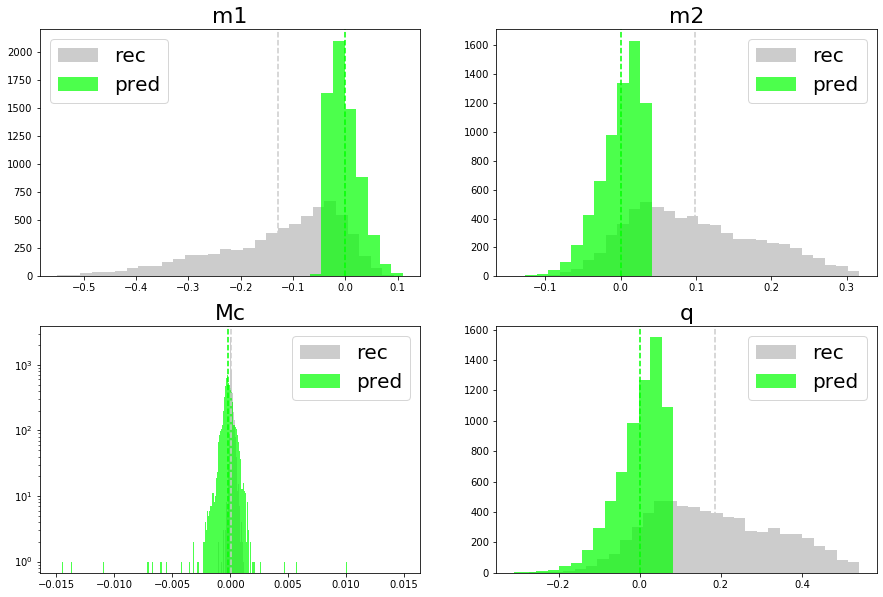

In [10]:
ErrorHistograms_m1m2(struct_m1m2, ytest_notnormalized, xtest_notnormalized)

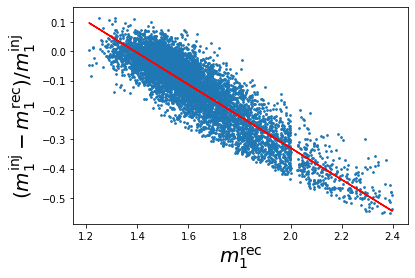

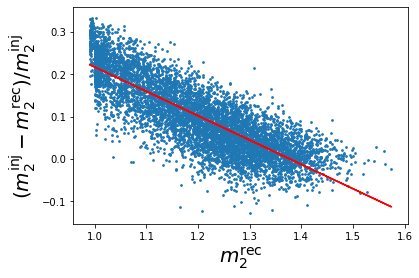

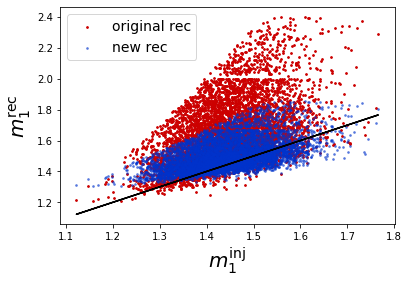

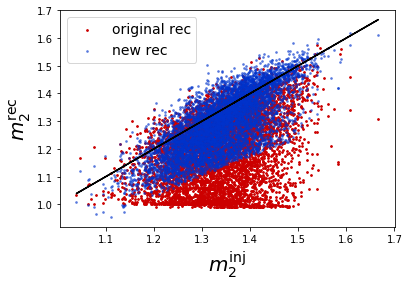

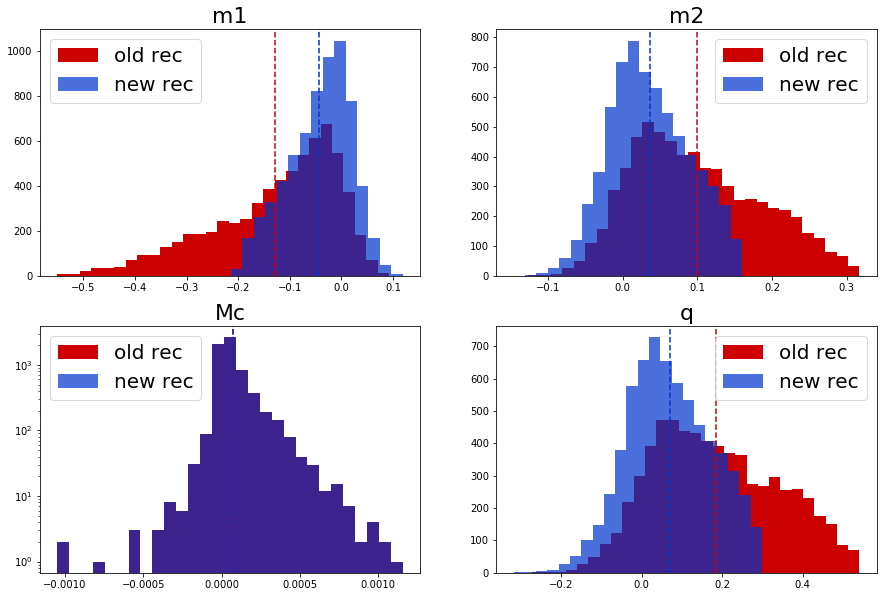

In [11]:
injected  = ytest_notnormalized
recovered = xtest_notnormalized

m1_inj  = injected[:,0]
m2_inj  = injected[:,1]
Mc_inj  = injected[:,2]
q_inj   = m2_inj /m1_inj

m1_rec  = recovered[:,0]
m2_rec  = recovered[:,1]
Mc_rec  = recovered[:,2]
q_rec   = m2_rec /m1_rec

prediction0 = struct_m1m2.prediction

#plt.figure
#plt.scatter(m1_inj,   recovered[:,0])
#plt.scatter(m1_inj, prediction0[:,0])
#plt.plot(m1_inj, m1_inj, color=[0,0,0])
#plt.show()

m1_error_rec = (m1_inj-m1_rec)/m1_inj
m2_error_rec = (m2_inj-m2_rec)/m2_inj
def BuildPoly(b,x):
    p = 0
    N = len(b)
    for i in range(0, N):
        p += b[i]*x**(N-i-1)
    return p

plt.figure
plt.scatter(m1_rec, m1_error_rec, s=3)
b = np.polyfit(m1_rec, m1_error_rec, 1)
p1 = BuildPoly(b, m1_rec)
plt.plot(m1_rec, p1, 'r')
plt.xlabel(r'$m_1^{\rm rec}$', fontsize=20)
plt.ylabel(r'$(m_1^{\rm inj}-m_1^{\rm rec})/m_1^{\rm inj}$', fontsize=20)
plt.show()

plt.figure
plt.scatter(m2_rec, m2_error_rec, s=3)
c = np.polyfit(m2_rec, m2_error_rec, 1)
p2 = BuildPoly(c, m2_rec)
plt.plot(m2_rec, p2, 'r')
plt.xlabel(r'$m_2^{\rm rec}$', fontsize=20)
plt.ylabel(r'$(m_2^{\rm inj}-m_2^{\rm rec})/m_2^{\rm inj}$', fontsize=20)
plt.show()

def CorrectMasses(m1_rec, m2_rec, Mc_rec):
    b = [-0.53999723,  0.75098645]
    correction = BuildPoly(b,m1_rec)
    new_m1_rec = m1_rec + correction
    new_m2_rec = ut.findSecondMassFromMc(Mc_rec, new_m1_rec)
    for i in range(0,len(m1_rec)):
        if new_m2_rec[i]>new_m1_rec[i]:
            tmp           = new_m1_rec[i]
            new_m1_rec[i] = new_m2_rec[i]
            new_m2_rec[i] = tmp
    return new_m1_rec, new_m2_rec
    

new_m1_rec, new_m2_rec = CorrectMasses(m1_rec, m2_rec, Mc_rec)

plt.figure
plt.scatter(m1_inj, m1_rec, color=[0.8,0,0], label='original rec', s=3)
plt.scatter(m1_inj, new_m1_rec, color=[0,0.2,0.8], label='new rec', s=3, alpha=0.5)
plt.plot(m1_inj, m1_inj, 'k')
plt.ylabel(r'$m_1^{\rm rec}$', fontsize=20)
plt.xlabel(r'$m_1^{\rm inj}$', fontsize=20)
plt.legend(fontsize=14)
plt.show()

plt.figure
plt.scatter(m2_inj, m2_rec, color=[0.8,0,0], label='original rec', s=3)
plt.scatter(m2_inj, new_m2_rec, color=[0,0.2,0.8], label='new rec', s=3, alpha=0.5)
plt.plot(m2_inj, m2_inj, 'k')
plt.ylabel(r'$m_2^{\rm rec}$', fontsize=20)
plt.xlabel(r'$m_2^{\rm inj}$', fontsize=20)
plt.legend(fontsize=14)
plt.show()


new_m1_rec_test,  new_m2_rec_test  = CorrectMasses(xtest_notnormalized[:,0], \
                                                   xtest_notnormalized[:,1], \
                                                   xtest_notnormalized[:,2])

new_recovered  = np.column_stack((new_m1_rec_test , new_m2_rec_test , Mc_rec))

fake_struct = lambda:0
fake_struct.prediction = new_recovered;
ErrorHistograms_m1m2(fake_struct, ytest_notnormalized, xtest_notnormalized, \
                     label1='old rec', label2='new rec', color1=[0.8,0,0], color2=[0,0.2,0.8])

********************************************************************************
Layers: 100 
trainable pramaters: 502
train time: 6.302
********************************************************************************

Final loss     : 0.03077
Final R2 mean  : 0.76285
R2[ 0]         : 0.74092
R2[ 1]         : 0.78479


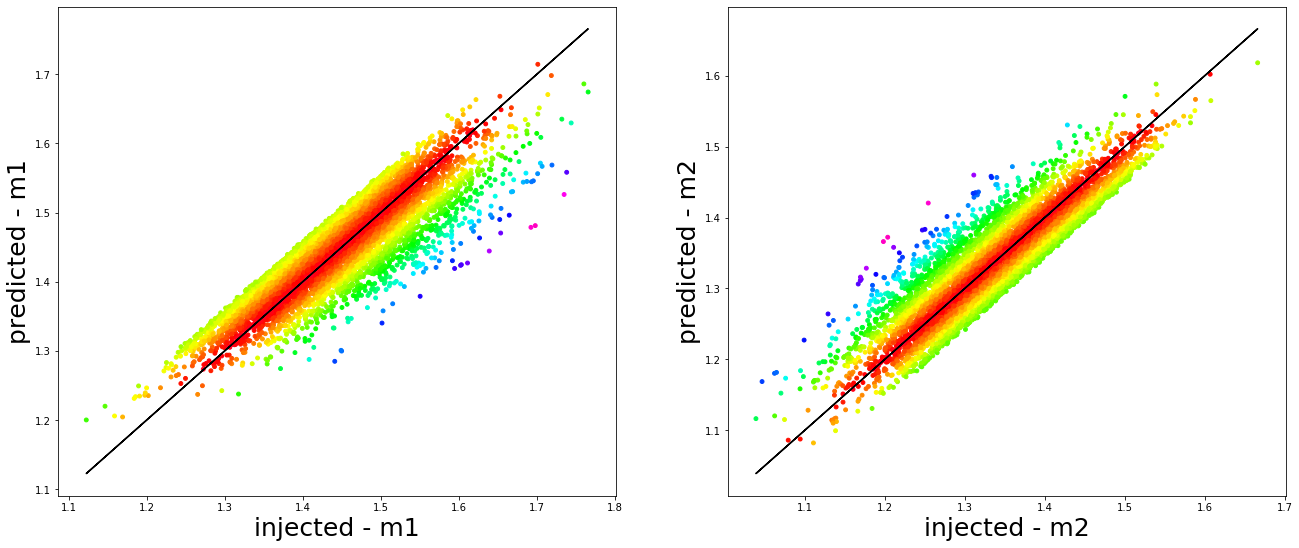

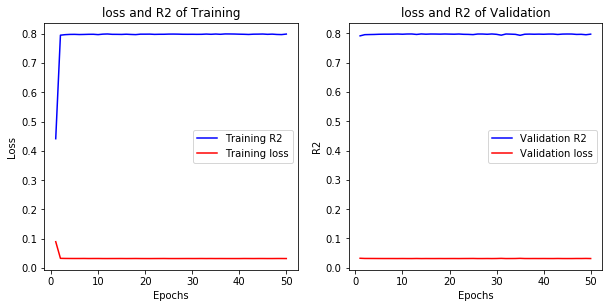

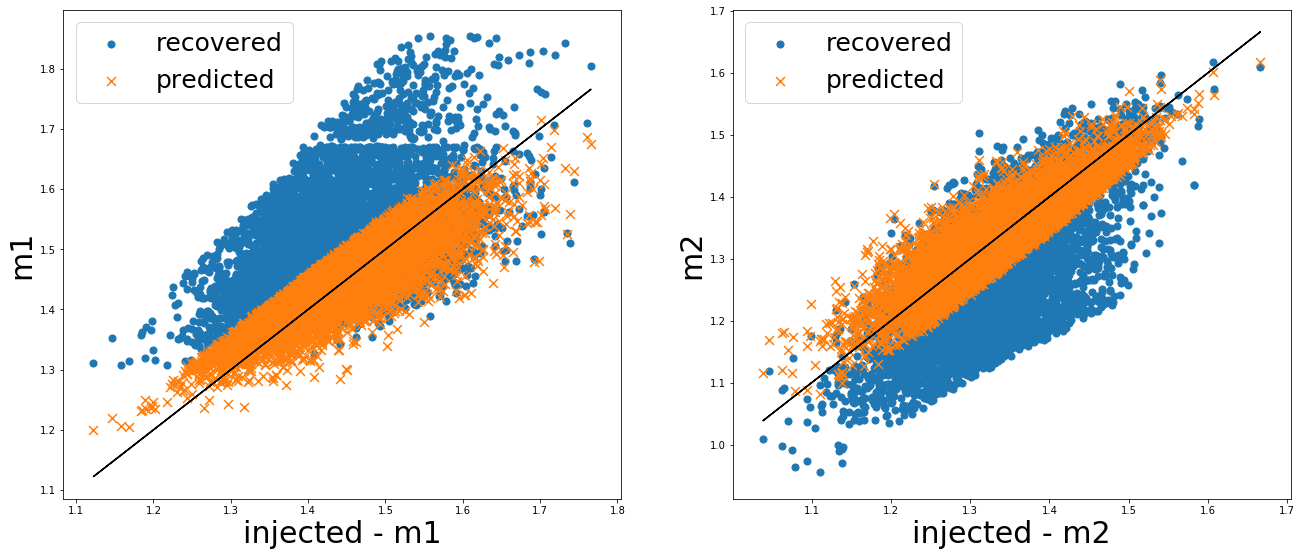

********************************************************************************
m1 vs m2: injected, recovered, predicted
********************************************************************************


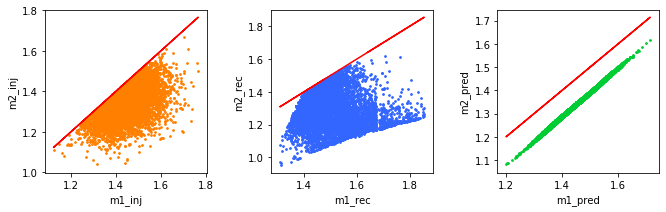

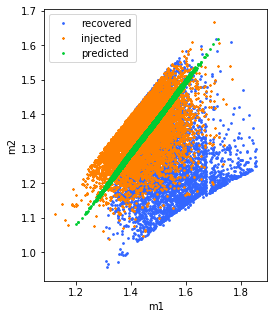

********************************************************************************
m1 vs q: injected, recovered, predicted (indirectly)
********************************************************************************


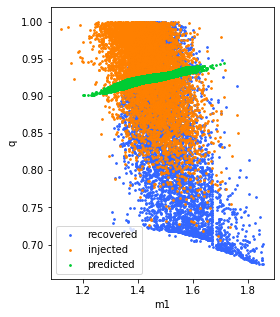

---------------------------------
m1 mean error: 0.02308783759125611
m2 mean error: 0.022613898122535697
Mc mean error: 0.0005956192377271302
q  mean error: 0.04595929612441984


In [12]:
epochs_m1m2c = 50

#xtrain_notnorm_m1m2c = xtrain_notnormalized[:,0:2]
#xtest_notnorm_m1m2c  = xtest_notnormalized[:,0:2]
new_m1_rec_train, new_m2_rec_train = CorrectMasses(xtrain_notnormalized[:,0], \
                                                   xtrain_notnormalized[:,1], \
                                                   xtrain_notnormalized[:,2])
new_m1_rec_test,  new_m2_rec_test  = CorrectMasses(xtest_notnormalized[:,0], \
                                                   xtest_notnormalized[:,1], \
                                                   xtest_notnormalized[:,2])

xtrain_notnorm_m1m2c = np.column_stack((new_m1_rec_train, new_m2_rec_train))
xtest_notnorm_m1m2c  = np.column_stack((new_m1_rec_test , new_m2_rec_test ))
ytrain_notnorm_m1m2c = ytrain_notnormalized[:,0:2]
ytest_notnorm_m1m2c  = ytest_notnormalized[:,0:2]
labels_m1m2c         = labels[0:2]

t0 = time.perf_counter()
outNN = neuralNewtorkRegression(xtrain_notnorm_m1m2c, ytrain_notnorm_m1m2c,
            scaler_type       = scaler_type,                   
            epochs            = epochs_m1m2c, 
            batch_size        = batch_size, 
            learning_rate     = learning_rate,          
            validation_split  = validation_split,   
            verbose           = verbose_training,             
            hlayers_sizes     = hlayers_sizes,          
            out_activation    = out_activation,        
            hidden_activation = hidden_activation,
            loss_function     = 'mse')
train_time = time.perf_counter()-t0

model    = outNN["model"]
history  = outNN["history"]
Npars    = outNN["Npars"]
scaler_x = outNN["scaler_x"]
scaler_y = outNN["scaler_y"]

xtest = scaler_x.transform(xtest_notnorm_m1m2c)
ytest = scaler_y.transform(ytest_notnorm_m1m2c)

# predict
ypredicted = model.predict(xtest)

# print some information
metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)

# show plots and print info
asterisks = '*'*80
print(asterisks)
print('Layers: ', end='')
for layer in hlayers_sizes:
    print(layer,end=' ')
print('\ntrainable pramaters: ', Npars, \
      '\ntrain time: {:.3f}'.format(train_time), '\n', \
      asterisks, sep='', end='\n')
ut.printMetrics(metrics_dict)

# save info/score/model in the dictionary
struct_m1m2c                     = lambda:0
struct_m1m2c.Npars               = Npars
struct_m1m2c.metrics             = metrics_dict
struct_m1m2c.train_time          = train_time
struct_m1m2c.Nlayers             = len(hlayers_sizes)
struct_m1m2c.hlayers_sizes       = hlayers_sizes
struct_m1m2c.epochs              = epochs
struct_m1m2c.batch_size          = batch_size
struct_m1m2c.scaler_type         = scaler_type
struct_m1m2c.out_activation      = out_activation
struct_m1m2c.hidden_activation   = hidden_activation
struct_m1m2c.learning_rate       = learning_rate
struct_m1m2c.prediction          = ypredicted
struct_m1m2c.prediction_rescaled = scaler_y.inverse_transform(ypredicted)
struct_m1m2c.loss_function       = loss_function
struct_m1m2c.scaler_x            = scaler_x
struct_m1m2c.scaler_y            = scaler_y
struct_m1m2c.model               = model
struct_m1m2c.history             = history

# plots
fp.regrPredictionPlots(ytest, ypredicted, labels_m1m2c, scaler=scaler_y)
fp.plotHistory(history)
fp.checkRegressionPlot(xtest, ytest, ypredicted, labels_m1m2c, \
                   scaler_y=scaler_y, scaler_x=scaler_x)
fp.plotInjRecPred(ytest_notnorm_m1m2c, xtest_notnorm_m1m2c, \
                  struct_m1m2c.prediction_rescaled, idx_Mc=None)

# mean errors 
m1_inj  = ytest_notnormalized[:,0]
m2_inj  = ytest_notnormalized[:,1]
Mc_inj  = ut.chirpMass(m1_inj, m2_inj)
m1_pred = struct_m1m2c.prediction_rescaled[:,0]
m2_pred = struct_m1m2c.prediction_rescaled[:,1]
Mc_pred = ut.chirpMass(m1_pred, m2_pred)
q_inj   = m2_inj /m1_inj
q_pred  = m2_pred/m1_pred

prediction_m1m2c = np.column_stack((m1_pred, m2_pred, Mc_pred))
struct_m1m2c.prediction = prediction_m1m2c

error_m1 = (m1_inj-m1_pred)/m1_inj
error_m2 = (m2_inj-m2_pred)/m2_inj
error_Mc = (Mc_inj-Mc_pred)/Mc_inj
error_q  = (q_inj - q_pred)/q_inj
m1_mean_error = np.mean(np.abs(error_m1))
m2_mean_error = np.mean(np.abs(error_m2))
Mc_mean_error = np.mean(np.abs(error_Mc))
q_mean_error  = np.mean(np.abs(error_q))
print('---------------------------------')
print('m1 mean error:', m1_mean_error)
print('m2 mean error:', m2_mean_error)
print('Mc mean error:', Mc_mean_error)
print('q  mean error:', q_mean_error)

struct_m1m2c.error_m1 = error_m1
struct_m1m2c.error_m2 = error_m2
struct_m1m2c.error_Mc = error_Mc
struct_m1m2c.error_q  = error_q
struct_m1m2c.me_m1 = m1_mean_error
struct_m1m2c.me_m2 = m2_mean_error
struct_m1m2c.me_Mc = Mc_mean_error
struct_m1m2c.me_q  =  q_mean_error

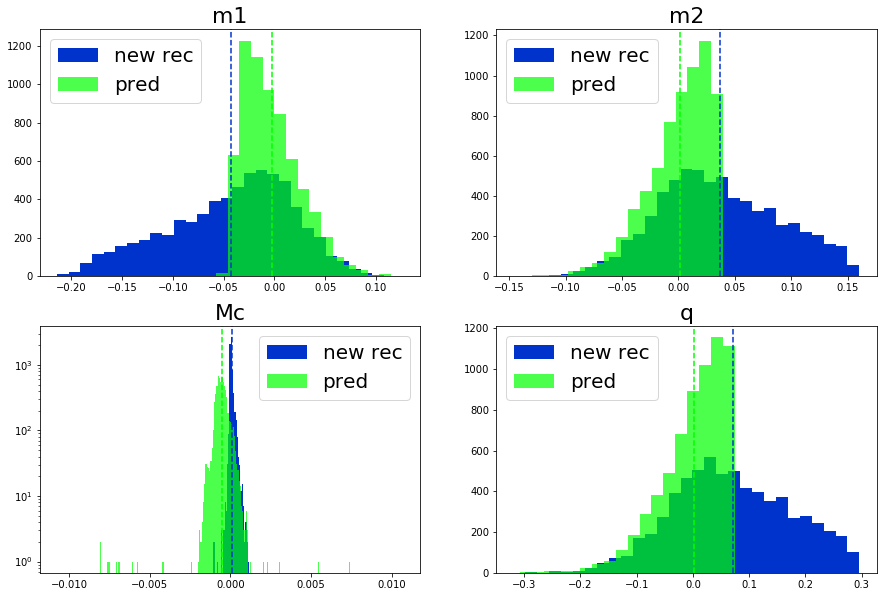

In [13]:
new_m1_rec_test,  new_m2_rec_test  = CorrectMasses(xtest_notnormalized[:,0], \
                                                   xtest_notnormalized[:,1], \
                                                   xtest_notnormalized[:,2])

new_recovered  = np.column_stack((new_m1_rec_test , new_m2_rec_test , Mc_rec))

ErrorHistograms_m1m2(struct_m1m2c, ytest_notnormalized, new_recovered, \
                     label1='new rec', label2='pred', color1=[0,0.2,0.8], color2=[0,1,0])